<a href="https://colab.research.google.com/github/ris0801/DeepLearning-Mini_project/blob/main/ResNet5M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ResNet5M: Optimizing CIFAR-10 Image Classification with Limited Parameters

In [ ]:
import torch
import torch.nn as nn
from typing import Type, List, Union
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

#ResNet Model
Resnet model having less than 5 million parameters

### One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.
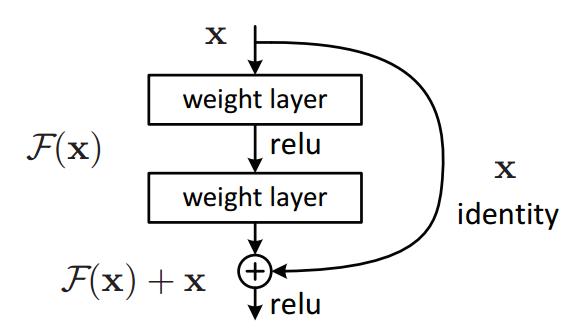

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes: int, out_planes: int, stride: int=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int=1
    def __init__(self, in_depth, out_depth, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_depth, out_depth, stride=stride)
        self.conv2 = conv3x3(out_depth, out_depth, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_depth)
        self.bn2 = nn.BatchNorm2d(out_depth)
        self.downsample=downsample

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

class BottleneckBlock(nn.Module):
    expansion: int = 4
    def __init__(self, in_depth, neck_depth, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = conv1x1(in_depth, neck_depth, stride = 1)
        self.conv2 = conv3x3(neck_depth, neck_depth, stride=stride)
        self.conv3 = conv1x1(neck_depth, neck_depth * self.expansion, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(neck_depth)
        self.bn2 = nn.BatchNorm2d(neck_depth)
        self.bn3 = nn.BatchNorm2d(neck_depth * self.expansion)
        self.downsample = downsample

    def forward(self,x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, block: Type[Union[BasicBlock, BottleneckBlock]], layers: List[int], num_classes: int = 10):
        super(ResNet, self).__init__()
        self.in_depth = 64

        self.block0 = nn.Sequential(
                nn.Conv2d(3, self.in_depth, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.in_depth),
                nn.ReLU(inplace=True),
                #nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                )
        self.block1 = self._make_layer(block, 64, layers[0]) 
        self.block2 = self._make_layer(block, 128, layers[1], stride=2) 
        self.block3 = self._make_layer(block, 256, layers[2], stride=2) 
        self.block4 = self._make_layer(block, 512, layers[3], stride=2) 
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
        '''
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') #He init for conv weights
            ##No need to initialize BN weights biases manually since they initialize to 1 and 0, respectively, by default.
        '''

    def _make_layer(self, block: Type[Union[BasicBlock, BottleneckBlock]], neck_depth: int, blocks: int, stride: int=1):
        downsample = None
        if stride != 1 or self.in_depth != neck_depth * block.expansion:
            downsample = nn.Sequential(
                    conv1x1(self.in_depth, neck_depth*block.expansion, stride),
                    nn.BatchNorm2d(neck_depth*block.expansion)
                    )
        layers = []

        layers.append(block(self.in_depth, neck_depth, stride, downsample))
        self.in_depth = neck_depth*block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_depth, neck_depth))

        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet():
    return ResNet(BasicBlock, [1,1,1,1])

###Using a GPU if avaiable 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = resnet()
model.to(device)

ResNet(
  (block0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(128, eps=

#Visualizing the model

In [ ]:
from torchsummary import summary

###Note: This lists the number of parameters: 4,903,242

In [ ]:
summary(model, (3, 32, 32))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 16, 16]          73,728
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [ ]:
dev = torch.device('cuda:0')

#Data preprocessing

###Normalization and data augmentation

**transforms_train:** For training data, it randomly crops the input image to 32x32 pixels with padding, flips it horizontally, converts it to a PyTorch tensor, and normalizes it by subtracting the mean and dividing by the standard deviation along each channel. \
**transforms_test:** For testing data, it only converts the input image to a PyTorch tensor and normalizes it using the same mean and standard deviation values as transforms_train.

The mean and standard deviation values provided are precomputed statistics for the CIFAR-10 dataset, which help to scale the input data to a suitable range for neural networks.

A good paper discussing the normalization statistics is: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

In [ ]:
transforms_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((.4914,.4822,.4465), (.2023,.1994,.2010))]
        )
transforms_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((.4914,.4822,.4465),(.2023, .1994, .2010))
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 27911610.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Some of the sample images from the training dataloader 
The colors may appear unusual due to the normalization process, which is also applied during inference. Upon close observation, you may notice the effects of cropping and reflection padding in some of the images, while detecting horizontal flip can be more challenging through visual inspection.

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

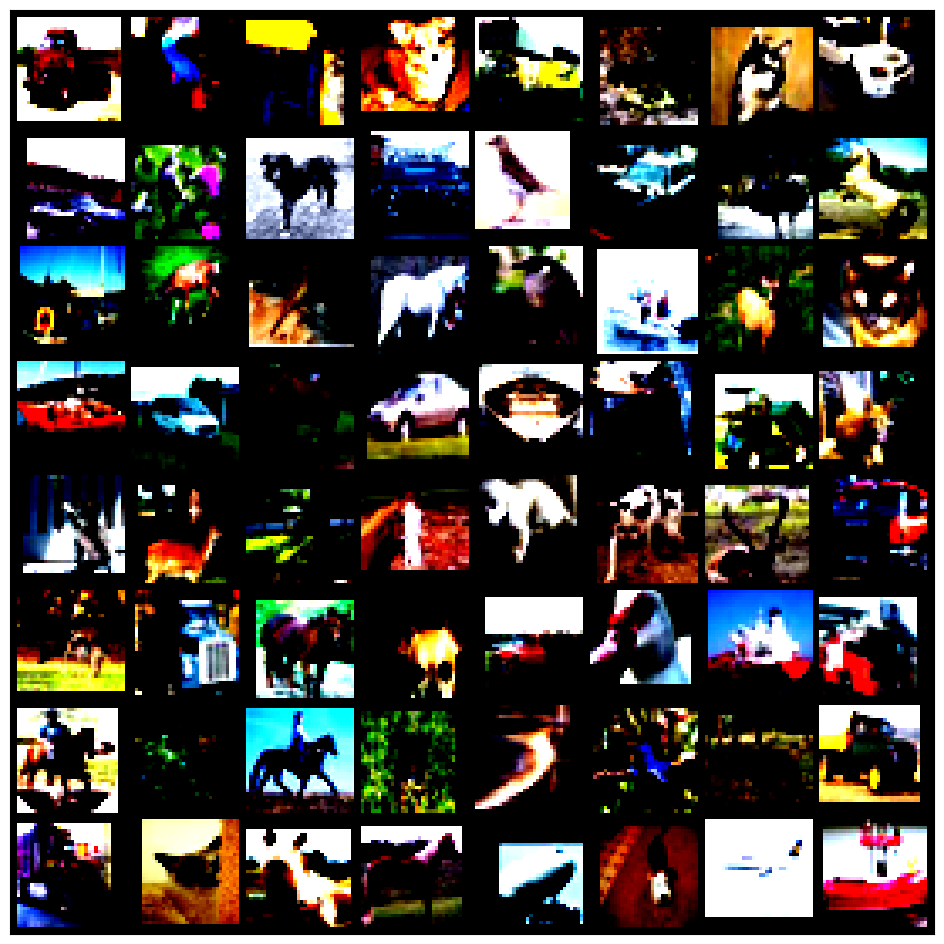

In [ ]:
show_batch(trainloader)

#Training the model 

**Learning rate scheduling:** The Cosine Annealing Learning Rate scheduler can be useful in training deep neural networks as it helps in improving model convergence and generalization. By gradually reducing the learning rate during training and then increasing it back, the scheduler can help the model to escape local optima and find better solutions in the parameter space. This can result in better training performance, faster convergence, and potentially higher accuracy on the validation or test set.

**Weight Decay:** We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

**Optimizer:** Using SGD optimizer for training a ResNet model on CIFAR-10 dataset can offer benefits such as memory and computation efficiency, fine-grained control over learning rate, potential for better generalization, customizable momentum, and potentially better performance on smaller datasets. However, the choice of optimizer should be based on various factors and experimentation to determine the best option for a specific scenario. 

We can reason using SGD, because it also proving best results from the weights and biases library sweeps we performed : https://wandb.ai/rishabh-rbs7261/pytorch-DL-Mini-Project/sweeps/9ttdzv2e?workspace=user-rbs7261


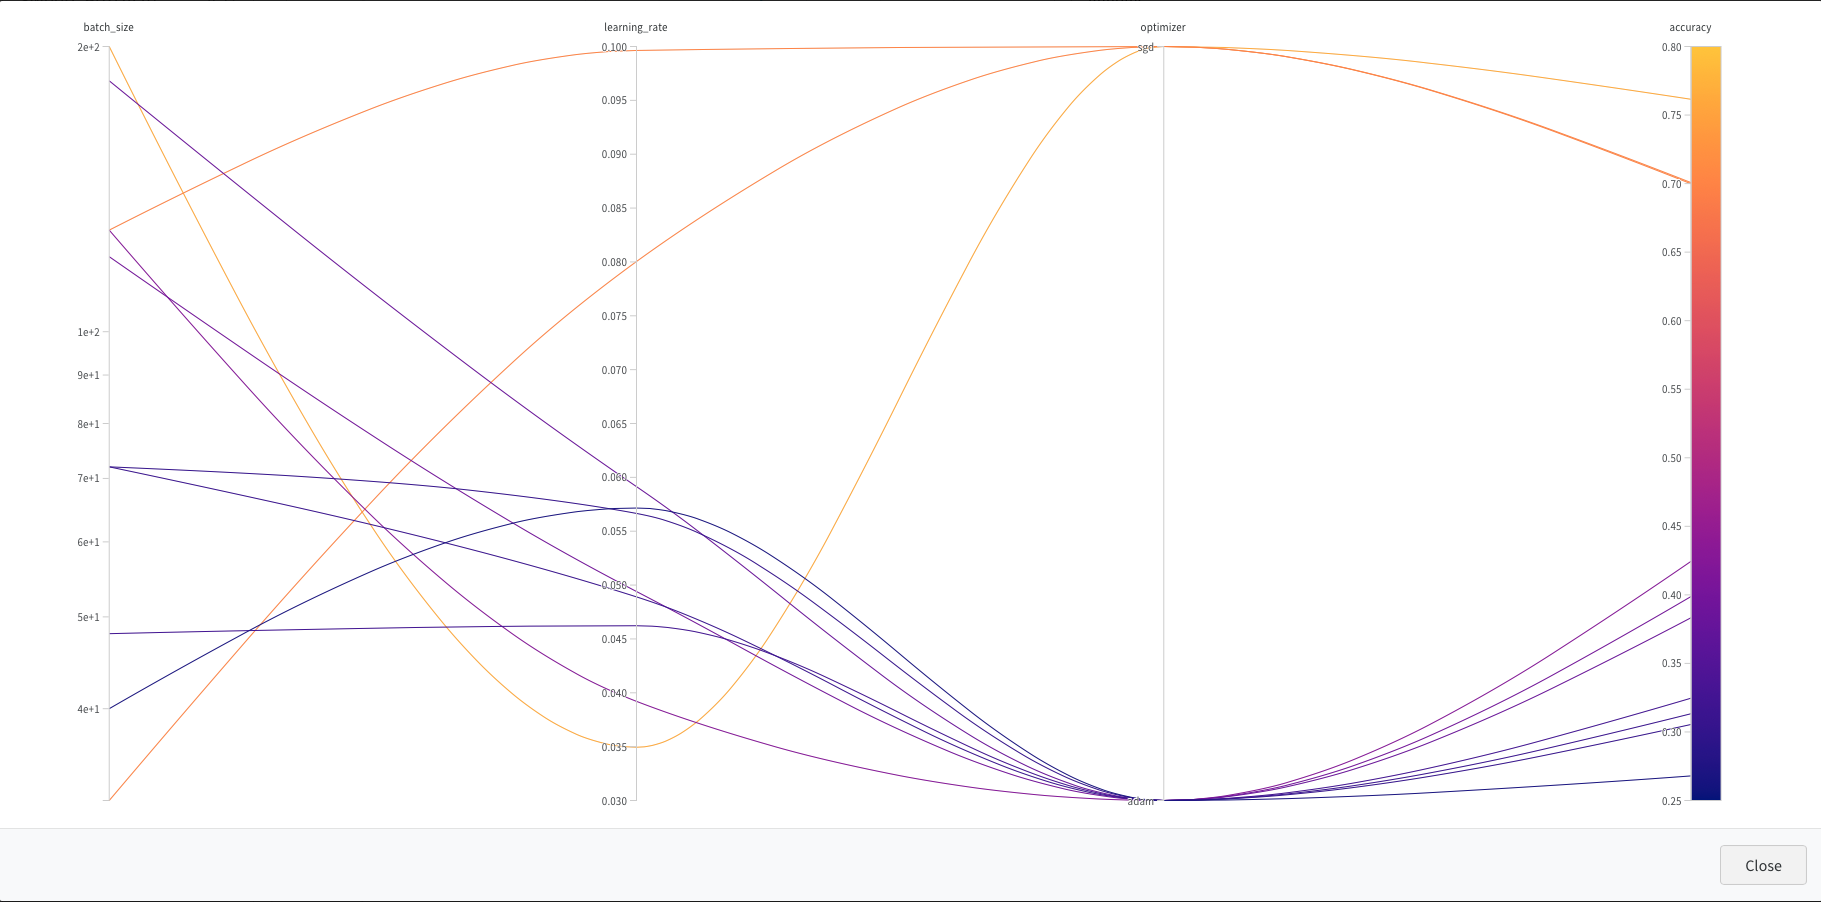

Intialising essential parameters for plotting

In [ ]:
best_accuracy = 0
train_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
test_loss_history = []
lr_history = []

### Hyperparameters and augmentation adopted from https://github.com/kuangliu/pytorch-cifar

In [ ]:
def train_epoch(model, criterion, optimizer, trainloader,lr_history):
    model.train()

    epoch_loss = .0
    matches = 0
    for samp, tru in trainloader:
        optimizer.zero_grad()
        res = model(samp.to(dev))
        loss = criterion(res, tru.to(dev))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #Train Acc
        _, pred = torch.max(res, 1)
        matches += torch.sum(torch.squeeze(pred.eq(tru.to(dev).data.view_as(pred))))
    epoch_acc = matches / float(len(trainloader)*trainloader.batch_size)
    avg_epoch_loss = epoch_loss/len(trainloader)

    # Append current learning rate to lr_history
    lr_history.append(optimizer.param_groups[0]['lr'])

    return avg_epoch_loss, epoch_acc

def test_epoch(model, criterion, testloader):
    model.eval()

    epoch_loss = .0
    matches = 0
    for samp, tru in testloader:
        res = model(samp.to(dev))
        loss = criterion(res, tru.to(dev))
        epoch_loss += loss.item()
        #Acc
        _, pred = torch.max(res, 1)
        matches += torch.sum(torch.squeeze(pred.eq(tru.to(dev).data.view_as(pred))))
    epoch_acc = matches / float(len(testloader)*testloader.batch_size)
    avg_epoch_loss = epoch_loss/len(testloader)
    return avg_epoch_loss, epoch_acc

def main():
    global best_accuracy
    global train_accuracy_history
    global test_accuracy_history
    global train_loss_history
    global test_loss_history
    global lr_history
    best_accuracy = 0
    train_accuracy_history = []
    test_accuracy_history = []
    train_loss_history = []
    test_loss_history = []
    lr_history = []
    num_epochs = 200
    lr = 0.1
    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=5e-4, lr=lr)
    criterion = torch.nn.CrossEntropyLoss().to(dev)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    for epoch in range(1, num_epochs+1):
        train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader,lr_history) 
        train_accuracy_history.append(train_acc) 
        train_loss_history.append(train_loss)
        print(f'Epoch: {epoch}, Train Loss: {train_loss}, Train Acc: {train_acc}')
        test_loss, test_acc = test_epoch(model, criterion, testloader)  
        test_accuracy_history.append(test_acc) 
        test_loss_history.append(test_loss)
        print(f'Epoch: {epoch}, Test Loss: {test_loss}, Test Acc: {test_acc}')
        scheduler.step()
            # Update best accuracy and save model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'resnet_cifar10_best.pth')

    print('Best Test Accuracy: {:.2f}%'.format(best_accuracy * 100.0))

if __name__=='__main__':
    main()

Epoch: 1, Train Loss: 1.5936384725448725, Train Acc: 0.41170474886894226
Epoch: 1, Test Loss: 1.3526707220077514, Test Acc: 0.513700008392334
Epoch: 2, Train Loss: 1.121806422310412, Train Acc: 0.5943294167518616
Epoch: 2, Test Loss: 1.0645322626829148, Test Acc: 0.6140999794006348
Epoch: 3, Train Loss: 0.9214218635388347, Train Acc: 0.6724944114685059
Epoch: 3, Test Loss: 0.99100790143013, Test Acc: 0.6556000113487244
Epoch: 4, Train Loss: 0.7915518562812025, Train Acc: 0.7170116901397705
Epoch: 4, Test Loss: 0.8314382237195969, Test Acc: 0.7181999683380127
Epoch: 5, Train Loss: 0.6789969772938877, Train Acc: 0.7623681426048279
Epoch: 5, Test Loss: 0.7942111092805862, Test Acc: 0.722000002861023
Epoch: 6, Train Loss: 0.607915110981373, Train Acc: 0.7879036068916321
Epoch: 6, Test Loss: 0.653660677075386, Test Acc: 0.7793999910354614
Epoch: 7, Train Loss: 0.560120191567999, Train Acc: 0.8060861229896545
Epoch: 7, Test Loss: 0.7879813814163208, Test Acc: 0.7443999648094177
Epoch: 8, Tra

##Best accuracy achieved on the test set is: 94.56999969482422

In [ ]:
print(f"Best accuracy is: {best_accuracy*100}")

Best accuracy is: 94.56999969482422


#Plotting

###Plotting train and test accuracies

In [ ]:
def plot_accuracies(train_accuracy_history, test_accuracy_history):
    # Convert train and test accuracy history to CPU
    train_accuracy_history_cpu = [acc.to('cpu') for acc in train_accuracy_history]
    test_accuracy_history_cpu = [acc.to('cpu') for acc in test_accuracy_history]

    # Number of epochs
    epochs = len(train_accuracy_history)

    # Generate x-axis values (epochs)
    x = range(1, epochs + 1)

    # Plot test accuracies vs epochs
    plt.plot(x, test_accuracy_history_cpu, label='Test Accuracy')

    # Plot train accuracies vs epochs
    plt.plot(x, train_accuracy_history_cpu, label='Train Accuracy')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test and Train Accuracies vs Epochs')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


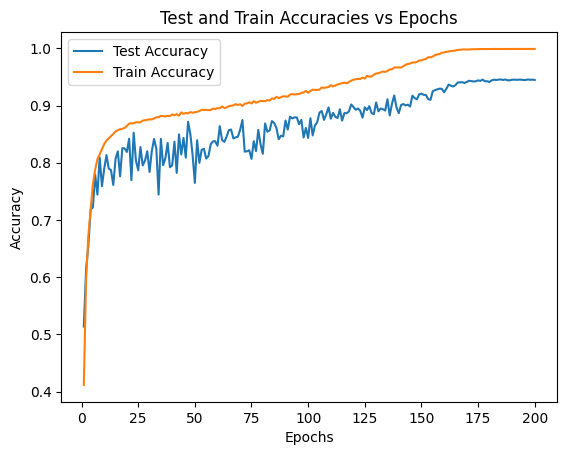

In [ ]:
# Call the function with your history of train and test accuracies
plot_accuracies(train_accuracy_history, test_accuracy_history)

The train accuracy of 100% suggests that the model has achieved a perfect accuracy on the training data, which may indicate overfitting, where the model has memorized the training data. The test accuracy of 95%, although slightly lower than the train accuracy, is still relatively high and indicates good performance on unseen data. However, the slight difference between train and test accuracy could suggest that the model may be slightly overfitting to the training data. Further analysis and optimization may be needed to address this issue and improve the model's generalization performance while adhering to the constraint on model size.

###Plotting train and test losses

In [ ]:
def plot_losses(train_loss_history, test_loss_history):
    # Number of epochs
    epochs = len(train_loss_history)

    # Generate x-axis values (epochs)
    x = range(1, epochs + 1)

    # Plot test losses vs epochs
    plt.plot(x, test_loss_history, label='Test Loss')

    # Plot train losses vs epochs
    plt.plot(x, train_loss_history, label='Train Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Test and Train Loss vs Epochs')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


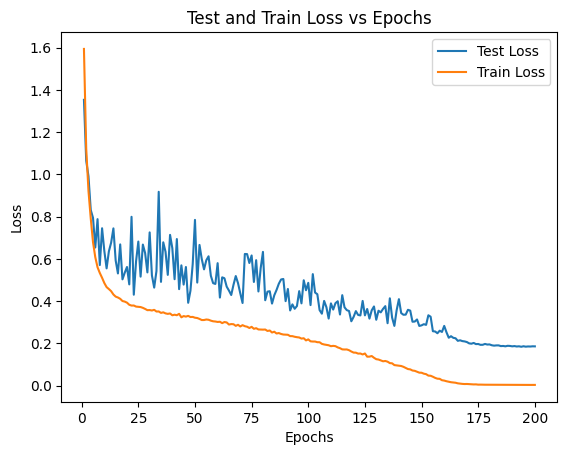

In [ ]:
# Call the function with your history of train and test losses
plot_losses(train_loss_history, test_loss_history)

The train loss at epoch 1 is 1.5936384725448725, which initially indicates relatively high training error or mispredictions by the model. However, at epoch 200, the train loss has significantly decreased to 0.0034262482517534664, indicating that the model has learned to better fit the training data over the course of training. Similarly, the test loss at epoch 200 has decreased to 0.18580105289816856, indicating significant improvement in the model's performance on the test data during training. In conclusion, the provided losses demonstrate improved model convergence over the 200 epochs, with decreasing train and test losses, suggesting improved model performance on both training and test data.

###Plotting learning rate change by epochs

In [ ]:
def plot_lr(lr_history):
    # Number of epochs
    epochs = len(lr_history)

    # Generate x-axis values (epochs)
    x = range(1, epochs + 1)

    # Plot learning rate vs epochs
    plt.plot(x, lr_history, label='Learning rate')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.title('Learning rate vs Epochs')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

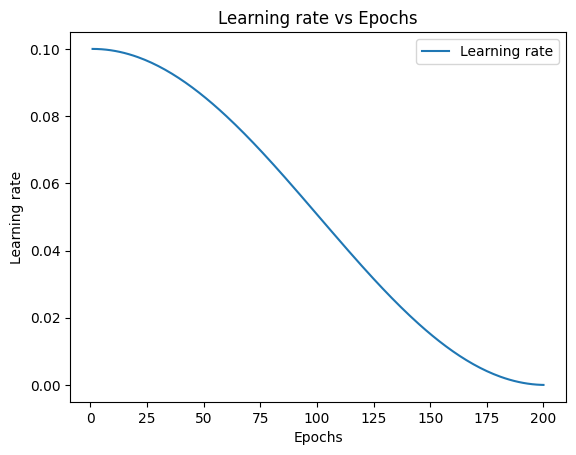

In [ ]:
plot_lr(lr_history)

The learning rate decreases over time, indicating that the model converges toward an optimal solution. A decreasing learning rate can help the model converge more slowly and avoid getting stuck in a suboptimal solution.
Initially, a high learning rate helps the model explore the solution space quickly and make more significant updates to the model's parameters. As the model converges, a lower learning rate helps it make more precise parameter adjustments and avoid overshooting the optimal solution.